# **5min stock data**

In this notebook we will explore a basic pipeline for 5min interval stock data. We will be working with a portfolio of highly correlated stocks: AAPL, GOOG, QCOM, and TSLA. We will train our models using the Balanced Focal Loss function and compare it to our previous performan using Categorical Cross Entropy Loss. These stocks were highly correlated around Aug - Oct 2022. The stock dataset contains timestamps, prices and trading volume, but does not contin any target variables.
- Timestamps &#8594; Interval
- Open/Close/High/Low Prices &#8594; Ratio
- Trading Volume &#8594; Ratio

To use the timestamps we will sinusoidally encode them. We will also add engineered features such as the price difference.

 We will create the target variable by taking the midpoint of Open/Close prices for M future days and then averaging these values. This target variable is Oridnal and has 3 possible classes: 
- 0 - downward price movement
- 1 - no change
- 2 - upward price movement

The price movements are derived by a threshold that is defined using the IQR method to detect outliers. Currently we use a limit of 1, and every Q1 outlier is classified as "0 - downward price movement", every Q3 outlier is classified as "2 - upward price movement", and all inliers are classified as: "1 - no change".

#### NOTE:
This dataset has discontinuities after each trading day (i.e. from final afterhours trade until the first afterhours trade the next day). It is possible that other afterhours activities could have occured to impact the prices during this time period. 

## Models

The main model we will be testing in this notebook is a Transformer Encoder. Typically a Transformer has an Encoder and Decoder portion, where the Encoder learns information about which parts of the input sequence are relevant to eachother. The Decoder does the opposite, it takes the continuouss representation learned by the Encoder and learns to generate an ordered output sequence. For the Time Series Classifiecation problem it is unecessary to include the Decoder, we can simply use the Encoder to learn relative correlations of the inputs and add a Vanilla Feed Forward Neural Network to the end of the Encoder Blocks to obtain the desired classification. [Source](https://userweb.cs.txstate.edu/~amk181/AIME_LSTM_Attention_vs_Transformer.pdf).

The Transformer Encoder also relies on positional encoding in order to implement this, we will first project the input vectors into high dimensional space as done [here](https://arxiv.org/pdf/2010.02803.pdf), and then add the positional Encoding as done in the [original paper](https://arxiv.org/pdf/1706.03762.pdf).


In order to compare how effective the Transformer is in modeling seuqential data, we will compare its results to:
- Baseline Model (uses previous predictions)
- Linear Model
- Neural Network
- LSTM

### Library Import

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

### Local Imports

Get base dir for imports, this allows us to look in the main algotrading folder to import local modules

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.path.abspath('..'), '..'))
sys.path.append(BASE_DIR)

In [3]:
from data_utils import *
from data_pipeline import *
from window_generator import WindowGenerator
from models.basic_transformer import TransformerModel

### Ensure that GPU is available

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Get the Data
Place all stocks in a Dictionary of DataFrames

In [5]:
from glob import glob
import re

# get all data .csvs
data_paths = glob(os.path.join(BASE_DIR, r'data\raw\5min\*.csv'))

# get stock DataFrames dict
stock_dfs = get_stocks(data_paths, tgt_window=4, iqr_lim=0.25)

c:\Users\itber\Documents\learning\school\ESE527\project\algotrading\data_pipeline.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_change'][df['price_trend'] < lower] = 0 # downward price movement
c:\Users\itber\Documents\learning\school\ESE527\project\algotrading\data_pipeline.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_change'][df['price_trend'] > upper] = 2 # upward prive movement
c:\Users\itber\Documents\learning\school\ESE527\project\algotrading\data_pipeline.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

### Plot the of number of each class for each stock

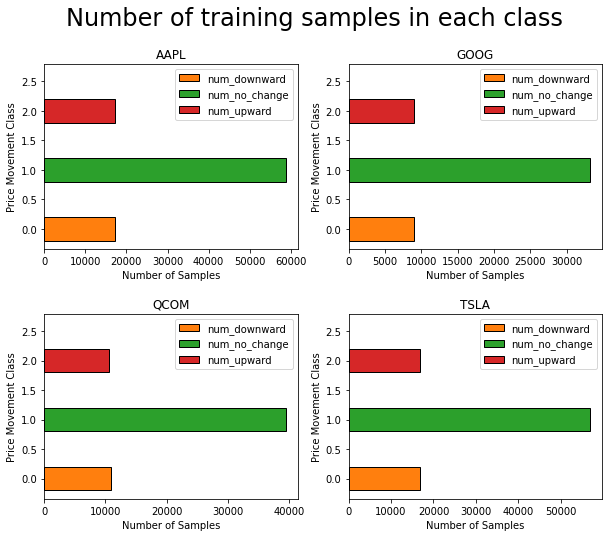

In [6]:
fig = plt.figure(figsize=(10, 8))

for i, name in enumerate(stock_dfs.keys()):
    # get plotting axes
    ax = plt.subplot(2, 2, i + 1)

    # get stock DataFrame
    df = stock_dfs[name]

    # compute class counts
    down = np.sum(df.price_change == 0)
    none = np.sum(df.price_change == 1)
    up = np.sum(df.price_change == 2)

    ax.barh([2.25], [0]) # expand to fit the legend
    ax.barh([0], [down], height=0.4, edgecolor='k', label='num_downward')
    ax.barh([1], [none], height=0.4, edgecolor='k', label='num_no_change')
    ax.barh([2], [up], height=0.4, edgecolor='k', label='num_upward')
    ax.set_title(name)
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Price Movement Class')
    ax.legend();

# set main title
fig.suptitle('Number of training samples in each class', size=24)

# add a bit of space
fig.subplots_adjust(hspace=0.35);


### Add Day of Week to features and remove later
We will use the dayofweek to remove windows containing non-consecutive data

In [6]:
for name in stock_dfs.keys():
    df = stock_dfs[name]
    df['dayofweek'] =  df.index.dayofweek

    stock_dfs[name] = df

In [7]:
stock_dfs['AAPL'].shape

(93274, 16)

In [8]:
print(stock_dfs['AAPL'].loc[:'2022-05-01'].shape)
print(stock_dfs['AAPL'].loc['2022-05-02':'2022-08-09'].shape)
print(stock_dfs['AAPL'].loc['2022-08-10':].shape)

(69493, 16)
(13015, 16)
(10766, 16)


### Get train, valid, test splits for each stock

In [9]:
split_dfs = get_split_dfs(stock_dfs, train_loc='2022-05-01', 
                          valid_loc_1='2022-05-02', valid_loc_2='2022-08-09', 
                          test_loc='2022-08-10')

### Get Data Generators
- One for baseline model
- One for simple non-sequential models (this will use window normalization)
- One for sequential models (This will use window normalization)

First we need to make a Data Generator that that can account for the time spans that we are interested in. We might be able to use specific timestamps to define the windows, i.e. 09:30-13:30

We should strive for a general method of doing this

### Get Data Generators
We will add data generators for each stock to dictionaries

In [95]:
base_gens = {}
single_gens = {}
window_gens = {}
    
for name in stock_dfs.keys():
    base_gen = WindowGenerator(
                input_width=1, label_width=1, shift=0,
                sample_weights=False,
                dfs=split_dfs[name],
                batch_size=32, 
                label_columns=['price_change'])

    single_gen = WindowGenerator(
                input_width=1, label_width=1, shift=0, 
                sample_weights=False,
                window_norm=False,
                dfs=split_dfs[name],
                remove_columns=['price_change', 'price_trend', 'dayofweek'],
                batch_size=32, 
                remove_nonsequential=True,
                label_columns=['price_change'])

    window_normed_gen = WindowGenerator(
                input_width=32, label_width=1, shift=0, 
                sample_weights=False,
                window_norm=True,
                dfs=split_dfs[name],
                remove_columns=['price_change', 'price_trend', 'dayofweek'],
                batch_size=32, 
                remove_nonsequential=True, # keep only simultaneous batch windows
                label_columns=['price_change'])

    # add to data generators
    base_gens.update({name : base_gen})
    single_gens.update({name : single_gen})
    window_gens.update({name : window_normed_gen})
        

In [96]:
for inputs, labels in window_gens['AAPL'].train.take(5):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 32, 13)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 32, 13)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 32, 13)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 32, 13)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 32, 13)
Labels shape (batch, time, features): (32, 1, 1)


### Start Training Models

In [97]:
def mcc_metric(y_true, y_pred, num_classes=3, threshold=0.5):
    ''' Custom Mathew Correlation Coefficient for multiclass 
        For more details see: 
            "https://en.wikipedia.org/wiki/Phi_coefficient"
        Inputs: 
            y_true (tensor)
            y_pred (tensor)
            num_classes - number of classes
        Outputs:
            mcc - Mathews Correlation Coefficient
        '''
    # obtain predictions here, we can add in a threshold if we would like to
    y_pred = tf.argmax(y_pred, axis=-1)

    # cast to int64
    y_true = tf.squeeze(tf.cast(y_true, tf.int64), axis=-1)
    y_pred = tf.cast(y_pred, tf.int64)

    # total number of samples
    s = tf.size(y_true, out_type=tf.int64)

    # total number of correctly predicted labels
    c = s - tf.math.count_nonzero(y_true - y_pred)
    
    # number of times each class truely occured
    t = []

    # number of times each class was predicted
    p = []

    for k in range(num_classes):
        k = tf.cast(k, tf.int64)
        
        # number of times that the class truely occured
        t.append(tf.reduce_sum(tf.cast(tf.equal(k, y_true), tf.int32)))

        # number of times that the class was predicted
        p.append(tf.reduce_sum(tf.cast(tf.equal(k, y_pred), tf.int32)))


    t = tf.expand_dims(tf.stack(t), 0)
    p = tf.expand_dims(tf.stack(p), 0)

    s = tf.cast(s, tf.int32)
    c = tf.cast(c, tf.int32)
    
    num = tf.cast(c*s - tf.matmul(t, tf.transpose(p)), tf.float32)
    dem = tf.math.sqrt(tf.cast(s**2 - tf.matmul(p, tf.transpose(p)), tf.float32)) \
          * tf.math.sqrt(tf.cast(s**2 - tf.matmul(t, tf.transpose(t)), tf.float32))


    mcc = tf.divide(num, dem + 1e-6)

    return mcc
    

In order to use Mathews Correlation Coefficient with predicted class probabilities, we will override thhe update_state function

In [98]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [99]:
train_performance = {}
val_performance = {}

In [100]:
for name in base_gens.keys():
    baseline = Baseline(label_index=base_gen.column_indices['price_change'])

    baseline.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=[mcc_metric, 'accuracy'],
                    # weighted_metrics=['accuracy'],
                    )

    train_performance[f'Baseline_{name}'] = baseline.evaluate(base_gens[name].train)
    val_performance[f'Baseline_{name}'] = baseline.evaluate(base_gens[name].valid)

400/400 [==============================] - 1s 3ms/step - loss: nan - mcc_metric: 0.0000e+00 - accuracy: 0.2061


Add a function to streamline the rest of the training process. First we will compute normalized class weights to help with the class imbalance.

In [101]:
def get_class_weights(dfs, name):
    class_counts = np.bincount(dfs[name][0].price_change)
    total = class_counts.sum()
    n_classes = len(class_counts)

    weights = []
    for idx, count in enumerate(class_counts):
        # compute balanced weights
        weights.append(total / (n_classes*count))

        # get inverse frequency class weighting
        # weights.append(1/np.power(count, 1))


    weights = np.array(weights) 
    # weights = weights / weights.sum()
    return weights

In [102]:
from focal_loss import SparseCategoricalFocalLoss

def compile_and_fit(model, window, lr=1e-4, max_epochs=100, lr_scheduler=None, patience=5, weights=None):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    
    model.compile(
        # loss=SparseCategoricalFocalLoss(gamma=2, class_weight=weights),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), mcc_metric],
        # weighted_metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

    if lr_scheduler:
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        history = model.fit(window.train, epochs=max_epochs,
                            validation_data=window.valid,
                            callbacks=[lr_callback, early_stopping])
    else:
        history = model.fit(window.train, epochs=max_epochs,
                            validation_data=window.valid,
                            callbacks=[early_stopping])
    return history

### Train the Linear model
Entire dataset is standardized here

In [103]:
linear_models = {}

for name in single_gens.keys():

    linear = tf.keras.Sequential([
        layers.Dense(units=3, activation='softmax')
    ])

    # weights = get_class_weights(split_dfs, name)
    history = compile_and_fit(linear, single_gens[name], lr=0.08, max_epochs=30, weights=None)

    linear_models.update({f'linear_{name}' : linear})
    train_performance[f'linear_{name}'] = linear.evaluate(single_gens[name].train, verbose=False)
    val_performance[f'linear_{name}'] = linear.evaluate(single_gens[name].valid, verbose=False)

Epoch 1/30
2172/2172 [==============================] - 14s 6ms/step - loss: 1.2062 - sparse_categorical_accuracy: 0.6224 - mcc_metric: 0.0947 - val_loss: 1.5503 - val_sparse_categorical_accuracy: 0.4379 - val_mcc_metric: 0.0879
Epoch 2/30
2172/2172 [==============================] - 12s 6ms/step - loss: 1.1552 - sparse_categorical_accuracy: 0.6308 - mcc_metric: 0.0961 - val_loss: 1.3985 - val_sparse_categorical_accuracy: 0.4373 - val_mcc_metric: 0.0880
Epoch 3/30
2172/2172 [==============================] - 13s 6ms/step - loss: 1.1552 - sparse_categorical_accuracy: 0.6309 - mcc_metric: 0.0990 - val_loss: 1.7599 - val_sparse_categorical_accuracy: 0.3830 - val_mcc_metric: 0.0723
Epoch 4/30
2172/2172 [==============================] - 12s 6ms/step - loss: 1.1582 - sparse_categorical_accuracy: 0.6313 - mcc_metric: 0.0974 - val_loss: 1.8545 - val_sparse_categorical_accuracy: 0.3840 - val_mcc_metric: 0.0772
Epoch 5/30
2172/2172 [==============================] - 13s 6ms/step - loss: 1.1397 

In [105]:
val_performance

{'Baseline_AAPL': [nan, 0.0, 0.22320400178432465],
 'Baseline_GOOG': [nan, 0.0, 0.215257465839386],
 'Baseline_QCOM': [nan, 0.0, 0.21873155236244202],
 'Baseline_TSLA': [nan, 0.0, 0.20606866478919983],
 'linear_AAPL': [1.5238393545150757, 0.42958125472068787, 0.08913545310497284],
 'linear_GOOG': [1.3434151411056519, 0.3188811242580414, 0.015764497220516205],
 'linear_QCOM': [1.0547120571136475, 0.4968701899051666, 0.11689107865095139],
 'linear_TSLA': [1.4702140092849731, 0.49448660016059875, 0.10098537802696228]}

### Train the transformer Model

Use learning rate schuler to warmpup Transformer learning rate

In [106]:
def lr_scheduler(epoch, lr, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [108]:
transformer_models = {}

for name in single_gens.keys():

    transformer_model = TransformerModel(
                                    n_heads=2,
                                    d_model=512,
                                    ff_dim=256,
                                    num_transformer_blocks=1,
                                    mlp_units=[256],
                                    n_outputs=3,
                                    dropout=0.1,
                                    mlp_dropout=0.1)

    # weights = get_class_weights(split_dfs, name)
    history = compile_and_fit(transformer_model, window_gens[name], lr=1e-6, max_epochs=30, 
                          lr_scheduler=lr_scheduler, patience=5)

    transformer_models.update({f'transformer_{name}' : transformer_model})
    train_performance[f'transformer_{name}'] = transformer_model.evaluate(window_gens[name].train, verbose=False)
    val_performance[f'transformer_{name}'] = transformer_model.evaluate(window_gens[name].valid, verbose=False)


Epoch 1/30
2171/2171 [==============================] - 61s 27ms/step - loss: 1.0401 - sparse_categorical_accuracy: 0.5115 - mcc_metric: -0.0055 - val_loss: 1.0321 - val_sparse_categorical_accuracy: 0.5242 - val_mcc_metric: -0.0059 - lr: 1.0000e-06
Epoch 2/30
2171/2171 [==============================] - 60s 28ms/step - loss: 0.8313 - sparse_categorical_accuracy: 0.6434 - mcc_metric: 0.0215 - val_loss: 0.9486 - val_sparse_categorical_accuracy: 0.5499 - val_mcc_metric: 0.1061 - lr: 6.7600e-05
Epoch 3/30
2171/2171 [==============================] - 60s 28ms/step - loss: 0.8075 - sparse_categorical_accuracy: 0.6517 - mcc_metric: 0.0899 - val_loss: 0.9840 - val_sparse_categorical_accuracy: 0.5304 - val_mcc_metric: 0.1597 - lr: 1.3420e-04
Epoch 4/30
2171/2171 [==============================] - 60s 27ms/step - loss: 0.7978 - sparse_categorical_accuracy: 0.6568 - mcc_metric: 0.1129 - val_loss: 0.9914 - val_sparse_categorical_accuracy: 0.5293 - val_mcc_metric: 0.1765 - lr: 2.0080e-04
Epoch 5/30

### Train the LSTM

In [112]:
lstm_models = {}

for name in single_gens.keys():

    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        # layers.LSTM(25, dropout=0.0, return_sequences=True),
        layers.LSTM(25, dropout=0.0),
        # Shape => [batch, time, features]
        # layers.TimeDistributed(layers.Dense(units=3, activation='softmax')),
        layers.Dense(units=3, activation='softmax'),
        layers.Reshape([1, -1])
    ])

    # weights = get_class_weights(split_dfs, name)
    history = compile_and_fit(transformer_model, window_gens[name], lr=0.005, max_epochs=30, 
                              patience=5)

    lstm_models.update({f'lstm_{name}' : lstm_models})
    train_performance[f'lstm_{name}'] = lstm_models.evaluate(window_gens[name].train, verbose=False)
    val_performance[f'lstm_{name}'] = lstm_models.evaluate(window_gens[name].valid, verbose=False)


Epoch 1/30
2171/2171 [==============================] - 61s 28ms/step - loss: 0.8685 - sparse_categorical_accuracy: 0.6419 - mcc_metric: 0.0398 - val_loss: 1.0020 - val_sparse_categorical_accuracy: 0.5372 - val_mcc_metric: 0.1200
Epoch 2/30
2171/2171 [==============================] - 60s 28ms/step - loss: 0.8480 - sparse_categorical_accuracy: 0.6521 - mcc_metric: 0.0703 - val_loss: 0.9761 - val_sparse_categorical_accuracy: 0.5519 - val_mcc_metric: 0.1673
Epoch 3/30
2171/2171 [==============================] - 61s 28ms/step - loss: 0.8344 - sparse_categorical_accuracy: 0.6534 - mcc_metric: 0.0791 - val_loss: 0.9937 - val_sparse_categorical_accuracy: 0.5489 - val_mcc_metric: 0.1739
Epoch 4/30
2171/2171 [==============================] - 59s 27ms/step - loss: 0.8417 - sparse_categorical_accuracy: 0.6532 - mcc_metric: 0.0810 - val_loss: 1.0224 - val_sparse_categorical_accuracy: 0.5388 - val_mcc_metric: 0.1835
Epoch 5/30
2171/2171 [==============================] - 59s 27ms/step - loss: 0.

In [113]:
train_performance

{'Baseline_AAPL': [nan, 0.0, 0.17250658571720123],
 'Baseline_GOOG': [nan, 0.0, 0.17368914186954498],
 'Baseline_QCOM': [nan, 0.0, 0.16974611580371857],
 'Baseline_TSLA': [nan, 0.0, 0.18433701992034912],
 'linear_AAPL': [2.0645980834960938, 0.39052852988243103, 0.05672554671764374],
 'linear_GOOG': [1.6996376514434814, 0.2846441864967346, 0.022803664207458496],
 'linear_QCOM': [1.0521388053894043, 0.5544300675392151, 0.09147047996520996],
 'linear_TSLA': [1.7513982057571411, 0.4700683653354645, 0.08654278516769409],
 'transformer_AAPL': [0.9866639971733093,
  0.49967238306999207,
  0.19455310702323914],
 'transformer_GOOG': [0.8812099695205688,
  0.6865711212158203,
  0.07174509763717651],
 'transformer_QCOM': [0.8338237404823303,
  0.6866649389266968,
  0.11423670500516891],
 'transformer_TSLA': [0.9290779829025269,
  0.5608723163604736,
  0.20469708740711212],
 'lstm_AAPL': [0.9899654388427734, 0.5537832975387573, 0.1464715301990509],
 'lstm_GOOG': [0.8691303730010986, 0.707916200160

In [114]:
val_performance

{'Baseline_AAPL': [nan, 0.0, 0.22320400178432465],
 'Baseline_GOOG': [nan, 0.0, 0.215257465839386],
 'Baseline_QCOM': [nan, 0.0, 0.21873155236244202],
 'Baseline_TSLA': [nan, 0.0, 0.20606866478919983],
 'linear_AAPL': [1.5238393545150757, 0.42958125472068787, 0.08913545310497284],
 'linear_GOOG': [1.3434151411056519, 0.3188811242580414, 0.015764497220516205],
 'linear_QCOM': [1.0547120571136475, 0.4968701899051666, 0.11689107865095139],
 'linear_TSLA': [1.4702140092849731, 0.49448660016059875, 0.10098537802696228],
 'transformer_AAPL': [0.9796975255012512,
  0.5290548205375671,
  0.19643597304821014],
 'transformer_GOOG': [0.9954694509506226,
  0.5436605215072632,
  0.04179302975535393],
 'transformer_QCOM': [0.9204387664794922,
  0.605720579624176,
  0.08696354180574417],
 'transformer_TSLA': [0.9299902319908142,
  0.5650826692581177,
  0.17820467054843903],
 'lstm_AAPL': [1.0053125619888306, 0.5261125564575195, 0.12908129394054413],
 'lstm_GOOG': [0.9564542174339294, 0.60635697841644

### Get Classification Performance

Function to get the predictions and labels

In [115]:
def get_label_preds(model, data_gen, threshold=0):
    ''' Obtains truth labels and predictions for a model/data_gen pair '''
    # get predictions
    prediction_vectors = model.predict(data_gen)
    predictions = tf.argmax(prediction_vectors, axis=-1)

    # get labels
    # labels = tf.concat([_labels for _, _labels, _ in data_gen], axis=0)
    labels = tf.concat([_labels for _, _labels in data_gen], axis=0)
    labels = tf.squeeze(labels, axis=-1)

    if threshold > 0:
        probs = tf.reduce_max(prediction_vectors, axis=-1)
        locs = probs > threshold

        predictions = predictions[locs]
        labels = labels[locs]

    return predictions, labels

In [116]:
base_train_preds, base_train_labels = get_label_preds(baseline, base_gen.train)
base_valid_preds, base_valid_labels = get_label_preds(baseline, base_gen.valid)

400/400 [==============================] - 0s 912us/step


In [118]:
linear_train_preds, linear_train_labels = get_label_preds(linear, 
                                                          single_gens['AAPL'].train,
                                                          threshold=0.)
linear_valid_preds, linear_valid_labels = get_label_preds(linear, 
                                                          single_gens['AAPL'].valid,
                                                          threshold=0.)

407/407 [==============================] - 1s 1ms/step


In [119]:
tf.math.confusion_matrix(tf.squeeze(linear_train_labels), linear_train_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 4817,  2797,  4374],
       [ 9458, 21368, 14613],
       [ 3955,  2719,  5392]])>

In [120]:
tf.math.confusion_matrix(tf.squeeze(linear_valid_labels), linear_valid_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 824,  736, 1345],
       [1178, 3445, 2599],
       [ 433,  745, 1710]])>

In [121]:
xformer_train_preds, xformer_train_labels = get_label_preds(transformer_model, 
                                                            window_gens['AAPL'].train,
                                                            threshold=0.)
xformer_valid_preds, xformer_valid_labels = get_label_preds(transformer_model, 
                                                            window_gens['AAPL'].valid,
                                                            threshold=0.)

406/406 [==============================] - 2s 4ms/step


In [ ]:
tf.math.confusion_matrix(tf.squeeze(xformer_train_labels), xformer_train_preds)

In [ ]:
tf.math.confusion_matrix(tf.squeeze(xformer_valid_labels), xformer_valid_preds)

In [ ]:
lstm_train_preds, lstm_train_labels = get_label_preds(lstm_model, 
                                                      window_gens['AAPL'].train,
                                                      threshold=0.)
lstm_valid_preds, lstm_valid_labels = get_label_preds(lstm_model, 
                                                      window_gens['AAPL'].valid,
                                                      threshold=0.)